# Capstone Project - The Battle of Neighborhoods

## 1.0 Introduction/Problem Statement

According to the 2010 census, New York City has the largest population of African-born residents with 233,000 people, mostly from Nigeria, Egypt, Ghana, Ethiopia, Morocco, Kenya, South Africa, Somalia, Sierra Leone, and Sudan. Besides these residents, thousands of tourists frequently visit New York City, prior COVID-19 (it is expected to continue at the same pace when things normalize). Although Africans love to cook in their homes and eat their local delicacies, they find it challenging to find restaurants where they can eat local foods when they go out, go to work, or on vacation. The purpose of this project is to visualize African restaurants in New York City to make it easy for both African residents and tourists to locate. Additionally, this project will provide information about (1) the best rated African restaurant(s) in New York City, (2) the areas with more concentration of African restaurants, and (3) the areas with a few or no African Restaurants.

## 2.0 Data

1.	https://cocl.us/new_york_dataset: This is a data source from New York City containing the list of boroughs and neighborhoods with their latitudes and longitudes.
2.	Foursquare API: The API will provide the location information of African restaurants
3.	https://data.cityofnewyork.us/City-Government/Borough-Boundaries/tqmj-j8zm: The data source has the borough boundaries information, which is expected to provide visualization of these boundaries.


## 3.0 Methodology

The data sets were collected from the data sources mentioned above in the Data section. The data source from New York City contains the list of boroughs, neighborhoods, and their geographical coordinates – https://cocl.us/new_york_dataset. The locations of African restaurants using Foursquare API and the visualization of the borough boundaries using https://data.cityofnewyork.us/City-Government/Borough-Boundaries/tqmj-j8zm. The restaurants will be analyzed and sorted using their ratings and will be visualized and ranked based on these ratings. The visualization of the neighborhoods will be achieved using folium library with Python. The data analysis and results will be done with Python programming using the Jupyter Notebook platform.

## 4.0 Data analysis and results

In [2]:
pip install geocoders

Note: you may need to restart the kernel to use updated packages.


In [11]:
# import libraries:

from bs4 import BeautifulSoup
import requests
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import geocoder
import os
import folium # this will create the map of New York City
from geopy.geocoders import Nominatim

# import Matplotlib modules:

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
%matplotlib inline

In [12]:
CLIENT_ID = "T3FCOB1I5G4VHT5FL2AVLU1NS4UAFEIPYKZ5SKXASFCW0WUQ"
CLIENT_SECRET = "2JV2WADCDANLSHT0LUKZ5CJF2L0OOYGZ2DRVTPI12YPTTUL4"
VERSION = '20200525'
LIMIT = 100
print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: T3FCOB1I5G4VHT5FL2AVLU1NS4UAFEIPYKZ5SKXASFCW0WUQ
CLIENT_SECRET:2JV2WADCDANLSHT0LUKZ5CJF2L0OOYGZ2DRVTPI12YPTTUL4


In [13]:
# define and obtain geo-location addresses

def geo_location(addr):
    geolocator = Nominatim(user_agent="newyork_explorer")
    location = geolocator.geocode(addr)
    latitude = location.latitude
    longitude = location.longitude
    return latitude, longitude

In [14]:
# define and obtain locations from Foursquare API - within 1000m and at least 100 locations.

def get_venues(lat,lng):
    
    #set variables
    radius=1000
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
    
    results = requests.get(url).json()
    venue_data=results["response"]['groups'][0]['items']
    venue_details=[]
    for row in venue_data:
        try:
            venue_id=row['venue']['id']
            venue_name=row['venue']['name']
            venue_category=row['venue']['categories'][0]['name']
            venue_details.append([venue_id,venue_name,venue_category])
        except KeyError:
            pass
        
    column_names=['ID','Name','Category']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df

In [15]:
# define and obtain the details of the locations via Foursquare API

def get_venue_details(venue_id):
        
    url = 'https://api.foursquare.com/v2/venues/{}?&client_id={}&client_secret={}&v={}'.format(
            venue_id,
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION)
    
    results = requests.get(url).json()
    venue_data=results['response']['venue']
    venue_details=[]
    try:
        venue_id=venue_data['id']
        venue_name=venue_data['name']
        venue_likes=venue_data['likes']['count']
        venue_rating=venue_data['rating']
        venue_tips=venue_data['tips']['count']
        venue_details.append([venue_id,venue_name,venue_likes,venue_rating,venue_tips])
    except KeyError:
        pass
        
    column_names=['ID','Name','Likes','Rating','Tips']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df

In [16]:
# define and obtain New York City boroughs, neighborhood and their coordinates

def get_new_york_data():
    url='https://cocl.us/new_york_dataset'
    resp=requests.get(url).json()
    # all data is present in features label
    features=resp['features']
    
    # define the dataframe columns
    column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 
    # instantiate the dataframe
    new_york_data = pd.DataFrame(columns=column_names)
    
    for data in features:
        borough = data['properties']['borough'] 
        neighborhood_name = data['properties']['name']
        
        neighborhood_coord = data['geometry']['coordinates']
        neighborhood_lat = neighborhood_coord[1]
        neighborhood_lon = neighborhood_coord[0]
    
        new_york_data = new_york_data.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)
    
    return new_york_data

In [17]:
# get New York City data

new_york_data=get_new_york_data()
new_york_data.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


In [18]:
# get the total number of neighborhoods in New York City

new_york_data.shape

(306, 4)

### Output 17 shows the first five neighborhoods with their borough and coordinates.
### Output 18 shows that their are a total of 306 neighborhoods in New York City.

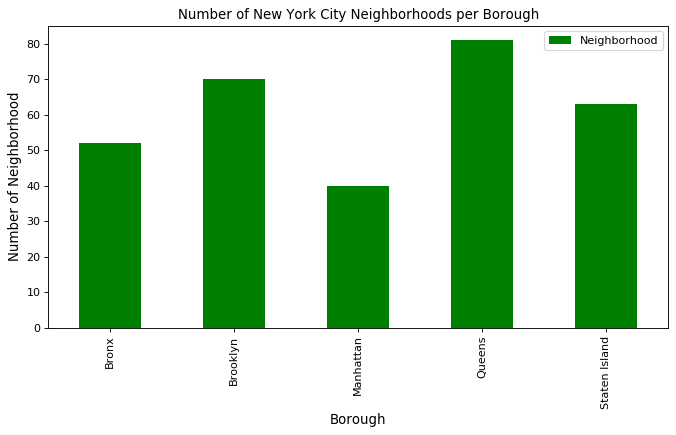

In [19]:
# Plot of a bar chart to show the number of neighborhood per borough

plt.figure(figsize=(10,5), dpi = 80)
plt.title('Number of New York City Neighborhoods per Borough')
plt.xlabel('Borough', fontsize = 12)
plt.ylabel('Number of Neighborhood', fontsize=12)
new_york_data.groupby('Borough')['Neighborhood'].count().plot(kind='bar', color='green')
plt.legend()

plt.show()

### The chart shows that there are 5 boroughs and Queens has the most number of neighborhoods while Manhattan has the least number of neighborhoods.

In [20]:
# Obtain the information of African restaurants per neighborhood

column_names=['Borough', 'Neighborhood', 'ID','Name']
african_rest_ny=pd.DataFrame(columns=column_names)
count=1
for row in new_york_data.values.tolist():
    Borough, Neighborhood, Latitude, Longitude=row
    venues = get_venues(Latitude,Longitude)
    african_restaurants=venues[venues['Category']=='African Restaurant']   
    print('(',count,'of',len(new_york_data),')','African Restaurants in '+Neighborhood+', '+Borough+':'+str(len(african_restaurants)))
    for restaurant_detail in african_restaurants.values.tolist():
        id, name , category=restaurant_detail
        african_rest_ny = african_rest_ny.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name
                                               }, ignore_index=True)
    count+=1

( 1 of 306 ) African Restaurants in Wakefield, Bronx:0
( 2 of 306 ) African Restaurants in Co-op City, Bronx:0
( 3 of 306 ) African Restaurants in Eastchester, Bronx:0
( 4 of 306 ) African Restaurants in Fieldston, Bronx:0
( 5 of 306 ) African Restaurants in Riverdale, Bronx:0
( 6 of 306 ) African Restaurants in Kingsbridge, Bronx:0
( 7 of 306 ) African Restaurants in Marble Hill, Manhattan:0
( 8 of 306 ) African Restaurants in Woodlawn, Bronx:0
( 9 of 306 ) African Restaurants in Norwood, Bronx:0
( 10 of 306 ) African Restaurants in Williamsbridge, Bronx:0
( 11 of 306 ) African Restaurants in Baychester, Bronx:0
( 12 of 306 ) African Restaurants in Pelham Parkway, Bronx:0
( 13 of 306 ) African Restaurants in City Island, Bronx:0
( 14 of 306 ) African Restaurants in Bedford Park, Bronx:0
( 15 of 306 ) African Restaurants in University Heights, Bronx:2
( 16 of 306 ) African Restaurants in Morris Heights, Bronx:0
( 17 of 306 ) African Restaurants in Fordham, Bronx:1
( 18 of 306 ) African

( 136 of 306 ) African Restaurants in Forest Hills, Queens:0
( 137 of 306 ) African Restaurants in Kew Gardens, Queens:0
( 138 of 306 ) African Restaurants in Richmond Hill, Queens:0
( 139 of 306 ) African Restaurants in Flushing, Queens:0
( 140 of 306 ) African Restaurants in Long Island City, Queens:0
( 141 of 306 ) African Restaurants in Sunnyside, Queens:0
( 142 of 306 ) African Restaurants in East Elmhurst, Queens:0
( 143 of 306 ) African Restaurants in Maspeth, Queens:0
( 144 of 306 ) African Restaurants in Ridgewood, Queens:0
( 145 of 306 ) African Restaurants in Glendale, Queens:0
( 146 of 306 ) African Restaurants in Rego Park, Queens:0
( 147 of 306 ) African Restaurants in Woodhaven, Queens:0
( 148 of 306 ) African Restaurants in Ozone Park, Queens:0
( 149 of 306 ) African Restaurants in South Ozone Park, Queens:0
( 150 of 306 ) African Restaurants in College Point, Queens:0
( 151 of 306 ) African Restaurants in Whitestone, Queens:0
( 152 of 306 ) African Restaurants in Baysi

( 267 of 306 ) African Restaurants in Astoria Heights, Queens:0
( 268 of 306 ) African Restaurants in Claremont Village, Bronx:0
( 269 of 306 ) African Restaurants in Concourse Village, Bronx:0
( 270 of 306 ) African Restaurants in Mount Eden, Bronx:0
( 271 of 306 ) African Restaurants in Mount Hope, Bronx:1
( 272 of 306 ) African Restaurants in Sutton Place, Manhattan:0
( 273 of 306 ) African Restaurants in Hunters Point, Queens:0
( 274 of 306 ) African Restaurants in Turtle Bay, Manhattan:0
( 275 of 306 ) African Restaurants in Tudor City, Manhattan:0
( 276 of 306 ) African Restaurants in Stuyvesant Town, Manhattan:0
( 277 of 306 ) African Restaurants in Flatiron, Manhattan:0
( 278 of 306 ) African Restaurants in Sunnyside Gardens, Queens:0
( 279 of 306 ) African Restaurants in Blissville, Queens:0
( 280 of 306 ) African Restaurants in Fulton Ferry, Brooklyn:0
( 281 of 306 ) African Restaurants in Vinegar Hill, Brooklyn:0
( 282 of 306 ) African Restaurants in Weeksville, Brooklyn:0
(

In [21]:
# African restaurants' analysis

african_rest_ny.head()

,Borough,Neighborhood,ID,Name
0,Bronx,University Heights,4c2f8b1b7cc0c9b6a1eaeb9a,Accra Resturant
1,Bronx,University Heights,4cb2beaadedbef3bca7c9d40,Papaye Restaurant
2,Bronx,Fordham,4cb2beaadedbef3bca7c9d40,Papaye Restaurant
3,Bronx,Belmont,4cb2beaadedbef3bca7c9d40,Papaye Restaurant
4,Brooklyn,Crown Heights,51d4d2cc454a777ed5a76c57,Cafe Rue Dix


In [22]:
african_rest_ny.shape

(13, 4)

###  Output 21 shows the first five African Restaurants
###  Output 22 shows that there are only 13 African Restaurants obtained via the Foursquare API

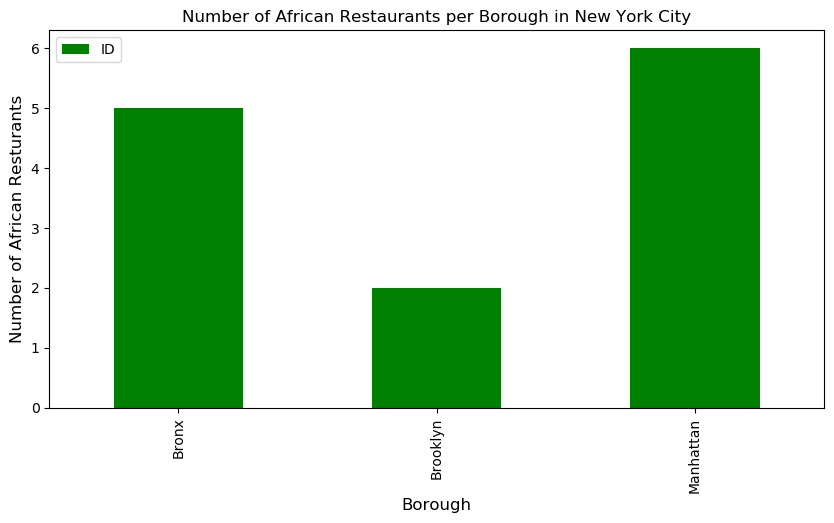

In [23]:
# Plot of a bar chart to show the number of African Restaurants per Borough

plt.figure(figsize=(10,5), dpi = 100)
plt.title('Number of African Restaurants per Borough in New York City')
plt.xlabel('Borough', fontsize = 12)
plt.ylabel('Number of African Resturants', fontsize=12)
african_rest_ny.groupby('Borough')['ID'].count().plot(kind='bar', color = 'green')
plt.legend()

plt.show()

###  The above result shows that:
1. Manhattan has the largest number of African restaurant, with a total of six (6) restaurants,
2. Bronx has the 2nd largest number of African restaurant, with a total of five (5) restaurants,
3. Brookly has only 2  African restaurants, and
4. Queens and Staten Island has no African Restaurants.

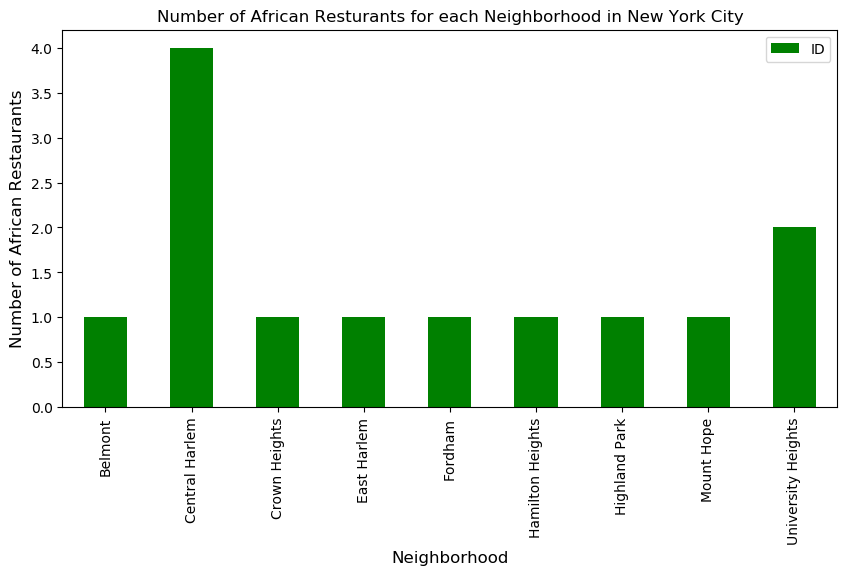

In [24]:
# Plot of a bar chart to show the number of African Restaurants per Neighborhood

plt.figure(figsize=(10,5), dpi = 100)
plt.title('Number of African Resturants for each Neighborhood in New York City')
plt.xlabel('Neighborhood', fontsize = 12)
plt.ylabel('Number of African Restaurants', fontsize=12)
african_rest_ny.groupby('Neighborhood')['ID'].count().plot(kind='bar', color = 'green')
plt.legend()

plt.show()

### The above result shows that:
1. Only nine out of 306 neighborhoods in New York City has African Restaurants,
2. Central Harlem has the largest number of African restaurant, with a total of six (4) restaurants

In [25]:
# Show all the restaurants in Central Harlem

african_rest_ny[african_rest_ny['Neighborhood']=='Central Harlem']

,Borough,Neighborhood,ID,Name
6,Manhattan,Central Harlem,53e01975498e78c0915599bf,Ponty Bistro Harlem
7,Manhattan,Central Harlem,4c2fdced452620a120551e0f,Keur Sokhna
8,Manhattan,Central Harlem,4a9ea132f964a520ad3a20e3,Africa Kine Restaurant
9,Manhattan,Central Harlem,5004a9e5e4b034c2950659fd,Les Ambassades Senegalais Bistro


In [26]:
# Create a list of neighborhoods with African restaurants

column_names=['Borough', 'Neighborhood', 'ID','Name','Likes','Rating','Tips']
african_rest_stats_ny=pd.DataFrame(columns=column_names)
count=1

for row in african_rest_ny.values.tolist():
    Borough,Neighborhood,ID,Name=row
    try:
        venue_details=get_venue_details(ID)
        print(venue_details)
        id,name,likes,rating,tips=venue_details.values.tolist()[0]
    except IndexError:
        print('No data available for id=',ID)
        id,name,likes,rating,tips=[0]*5
    print('(',count,'of',len(african_rest_ny),')','processed')
    african_rest_stats_ny = african_rest_stats_ny.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name,
                                                'Likes' : likes,
                                                'Rating' : rating,
                                                'Tips' : tips
                                               }, ignore_index=True)
    count+=1

                         ID             Name  Likes  Rating  Tips
0  4c2f8b1b7cc0c9b6a1eaeb9a  Accra Resturant      9     7.3     3
( 1 of 13 ) processed
                         ID               Name  Likes  Rating  Tips
0  4cb2beaadedbef3bca7c9d40  Papaye Restaurant     11     7.5     3
( 2 of 13 ) processed
                         ID               Name  Likes  Rating  Tips
0  4cb2beaadedbef3bca7c9d40  Papaye Restaurant     11     7.5     3
( 3 of 13 ) processed
                         ID               Name  Likes  Rating  Tips
0  4cb2beaadedbef3bca7c9d40  Papaye Restaurant     11     7.5     3
( 4 of 13 ) processed
                         ID          Name  Likes  Rating  Tips
0  51d4d2cc454a777ed5a76c57  Cafe Rue Dix    201     8.4    59
( 5 of 13 ) processed
                         ID                 Name  Likes  Rating  Tips
0  53e01975498e78c0915599bf  Ponty Bistro Harlem    105     8.6    30
( 6 of 13 ) processed
                         ID                 Name  Likes  Ratin

In [27]:
african_rest_stats_ny.head()

,Borough,Neighborhood,ID,Name,Likes,Rating,Tips
0,Bronx,University Heights,4c2f8b1b7cc0c9b6a1eaeb9a,Accra Resturant,9,7.3,3
1,Bronx,University Heights,4cb2beaadedbef3bca7c9d40,Papaye Restaurant,11,7.5,3
2,Bronx,Fordham,4cb2beaadedbef3bca7c9d40,Papaye Restaurant,11,7.5,3
3,Bronx,Belmont,4cb2beaadedbef3bca7c9d40,Papaye Restaurant,11,7.5,3
4,Brooklyn,Crown Heights,51d4d2cc454a777ed5a76c57,Cafe Rue Dix,201,8.4,59


In [28]:
african_rest_stats_ny.shape

(13, 7)

In [29]:
# Save the above data in CSV and verify the data from the CSV file

african_rest_stats_ny.to_csv('african_rest_stats_ny.csv', index=False)

In [30]:
african_rest_stats_ny_csv=pd.read_csv('african_rest_stats_ny.csv') # verify

In [31]:
african_rest_stats_ny_csv.head()

,Borough,Neighborhood,ID,Name,Likes,Rating,Tips
0,Bronx,University Heights,4c2f8b1b7cc0c9b6a1eaeb9a,Accra Resturant,9,7.3,3
1,Bronx,University Heights,4cb2beaadedbef3bca7c9d40,Papaye Restaurant,11,7.5,3
2,Bronx,Fordham,4cb2beaadedbef3bca7c9d40,Papaye Restaurant,11,7.5,3
3,Bronx,Belmont,4cb2beaadedbef3bca7c9d40,Papaye Restaurant,11,7.5,3
4,Brooklyn,Crown Heights,51d4d2cc454a777ed5a76c57,Cafe Rue Dix,201,8.4,59


In [32]:
african_rest_stats_ny_csv.shape

(13, 7)

In [33]:
african_rest_stats_ny.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13 entries, 0 to 12
Data columns (total 7 columns):
Borough         13 non-null object
Neighborhood    13 non-null object
ID              13 non-null object
Name            13 non-null object
Likes           13 non-null object
Rating          13 non-null float64
Tips            13 non-null object
dtypes: float64(1), object(6)
memory usage: 856.0+ bytes


In [34]:
# Covert 'Likes' and 'Tips' into float

african_rest_stats_ny['Likes']=african_rest_stats_ny['Likes'].astype('float64')

In [35]:
african_rest_stats_ny['Tips']=african_rest_stats_ny['Tips'].astype('float64')

In [36]:
african_rest_stats_ny.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13 entries, 0 to 12
Data columns (total 7 columns):
Borough         13 non-null object
Neighborhood    13 non-null object
ID              13 non-null object
Name            13 non-null object
Likes           13 non-null float64
Rating          13 non-null float64
Tips            13 non-null float64
dtypes: float64(3), object(4)
memory usage: 856.0+ bytes


### The above result shows that 'Likes,' 'Ratings,' and 'Tips' are now float and can be manipulated mathematically

In [37]:
# Restaurant with maximum Likes

african_rest_stats_ny.iloc[african_rest_stats_ny['Likes'].idxmax()]

Borough                         Brooklyn
Neighborhood               Crown Heights
ID              51d4d2cc454a777ed5a76c57
Name                        Cafe Rue Dix
Likes                                201
Rating                               8.4
Tips                                  59
Name: 4, dtype: object

In [38]:
# Restaurant with minimum Likes

african_rest_stats_ny.iloc[african_rest_stats_ny['Likes'].idxmin()]

Borough                            Bronx
Neighborhood          University Heights
ID              4c2f8b1b7cc0c9b6a1eaeb9a
Name                     Accra Resturant
Likes                                  9
Rating                               7.3
Tips                                   3
Name: 0, dtype: object

In [39]:
# Restaurant with maximum Rating

african_rest_stats_ny.iloc[african_rest_stats_ny['Rating'].idxmax()]

Borough                        Manhattan
Neighborhood            Hamilton Heights
ID              53e01975498e78c0915599bf
Name                 Ponty Bistro Harlem
Likes                                105
Rating                               8.6
Tips                                  30
Name: 5, dtype: object

In [40]:
# Restaurant with minimum Rating

african_rest_stats_ny.iloc[african_rest_stats_ny['Rating'].idxmin()]

Borough                         Brooklyn
Neighborhood               Highland Park
ID              4b1eefb3f964a520c72124e3
Name                        Festac Grill
Likes                                  9
Rating                                 6
Tips                                  11
Name: 12, dtype: object

In [41]:
# Restaurant with maximum Tips

african_rest_stats_ny.iloc[african_rest_stats_ny['Tips'].idxmax()]

Borough                         Brooklyn
Neighborhood               Crown Heights
ID              51d4d2cc454a777ed5a76c57
Name                        Cafe Rue Dix
Likes                                201
Rating                               8.4
Tips                                  59
Name: 4, dtype: object

In [42]:
# Restaurant with minimum Tips

african_rest_stats_ny.iloc[african_rest_stats_ny['Tips'].idxmin()]

Borough                            Bronx
Neighborhood          University Heights
ID              4c2f8b1b7cc0c9b6a1eaeb9a
Name                     Accra Resturant
Likes                                  9
Rating                               7.3
Tips                                   3
Name: 0, dtype: object

In [43]:
# Synthesize rating information per Neighborhood

ny_neighborhood_stats=african_rest_stats_ny.groupby('Neighborhood',as_index=False).mean()[['Neighborhood','Rating']]
ny_neighborhood_stats.columns=['Neighborhood','Average Rating']

In [44]:
ny_neighborhood_stats.sort_values(['Average Rating'],ascending=False).head(12)

,Neighborhood,Average Rating
3,East Harlem,8.60
5,Hamilton Heights,8.60
2,Crown Heights,8.40
1,Central Harlem,7.75
0,Belmont,7.50
4,Fordham,7.50
8,University Heights,7.40
7,Mount Hope,7.30
6,Highland Park,6.00


In [45]:
# Synthesize rating information per Borough

ny_borough_stats=african_rest_stats_ny.groupby('Borough',as_index=False).mean()[['Borough','Rating']]
ny_borough_stats.columns=['Borough','Average Rating']

In [46]:
ny_borough_stats.sort_values(['Average Rating'],ascending=False).head()

,Borough,Average Rating
2,Manhattan,8.033333
0,Bronx,7.420000
1,Brooklyn,7.200000


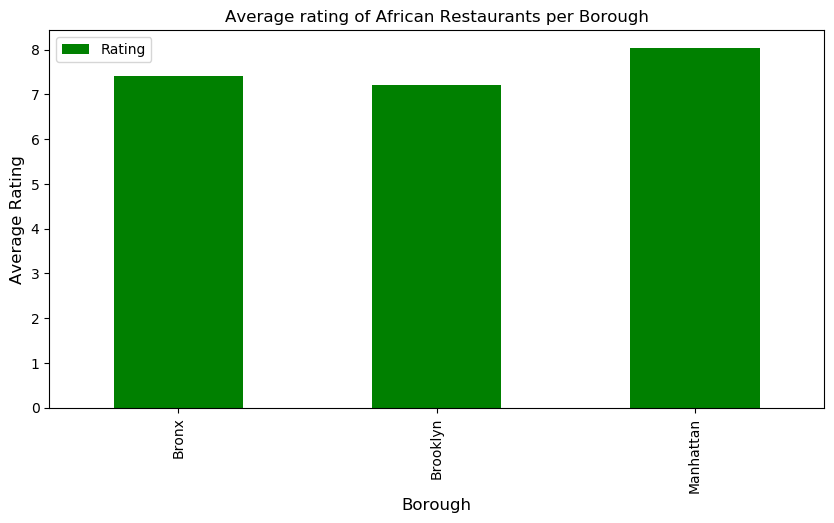

In [47]:
# Plot of bar chart to show Average Ranking per Borough

plt.figure(figsize=(10,5), dpi = 100)
plt.title('Average rating of African Restaurants per Borough')
plt.xlabel('Borough', fontsize = 12)
plt.ylabel('Average Rating', fontsize=12)
african_rest_stats_ny.groupby('Borough').mean()['Rating'].plot(kind='bar', color = 'green')
plt.legend()

plt.show()

### For this project, neighborhoods with average rating greater or equal 7.0 will be visualize on the map

In [48]:
ny_neighborhood_stats=ny_neighborhood_stats[ny_neighborhood_stats['Average Rating']>=7.0]

In [49]:
ny_neighborhood_stats

,Neighborhood,Average Rating
0,Belmont,7.50
1,Central Harlem,7.75
2,Crown Heights,8.40
3,East Harlem,8.60
4,Fordham,7.50
5,Hamilton Heights,8.60
7,Mount Hope,7.30
8,University Heights,7.40


In [50]:
# Merge Neighborhoods and coordinates

ny_neighborhood_stats=pd.merge(ny_neighborhood_stats,new_york_data, on='Neighborhood')

In [51]:

ny_neighborhood_stats=ny_neighborhood_stats[['Borough','Neighborhood','Latitude','Longitude','Average Rating']]

In [52]:
ny_neighborhood_stats

,Borough,Neighborhood,Latitude,Longitude,Average Rating
0,Bronx,Belmont,40.857277,-73.888452,7.50
1,Manhattan,Central Harlem,40.815976,-73.943211,7.75
2,Brooklyn,Crown Heights,40.670829,-73.943291,8.40
3,Manhattan,East Harlem,40.792249,-73.944182,8.60
4,Bronx,Fordham,40.860997,-73.896427,7.50
5,Manhattan,Hamilton Heights,40.823604,-73.949688,8.60
6,Bronx,Mount Hope,40.848842,-73.908299,7.30
7,Bronx,University Heights,40.855727,-73.910416,7.40


In [53]:
# create map and display the locations

ny_map = folium.Map(location=geo_location('New York'), zoom_start=12)

In [54]:
incidents = folium.map.FeatureGroup()

for lat, lng, in ny_neighborhood_stats[['Latitude','Longitude']].values:
    incidents.add_child(
        folium.CircleMarker(
            [lat, lng],
            radius=10, 
            color='brown',
            fill=True,
            fill_color='purple',
            fill_opacity=0.6
        )
    )

In [55]:
# labels and markers


ny_neighborhood_stats['Label']=ny_neighborhood_stats['Neighborhood']+', '+ny_neighborhood_stats['Borough']+'('+ny_neighborhood_stats['Average Rating'].map(str)+')'

In [56]:
for lat, lng, label in ny_neighborhood_stats[['Latitude','Longitude','Label']].values:
    folium.Marker([lat, lng], popup=label).add_to(ny_map)        

ny_map.add_child(incidents)

In [62]:
# New York Map

ny_map = folium.Map(location=geo_location('New York'), zoom_start=12)
ny_geo = r'C:/nyu_2451_34572-geojson.json'

ny_map.choropleth(
    geo_data=ny_geo,
    data=ny_borough_stats,
    columns=['Borough', 'Average Rating'],
    key_on='feature.properties.boro_name',
    fill_color='YlOrRd', 
    fill_opacity=0.6, 
    line_opacity=0.2,
    legend_name='Average Rating'
)

ny_map.save('borough_rating.html')

In [63]:
# New York Map output

ny_map = folium.Map(location=geo_location('New York'), zoom_start=12)
ny_geo = r'C:/nyu_2451_34572-geojson.json'

ny_map.choropleth(
    geo_data=ny_geo,
    data=ny_borough_stats,
    columns=['Borough', 'Average Rating'],
    key_on='feature.properties.boro_name',
    fill_color='YlOrRd', 
    fill_opacity=0.6, 
    line_opacity=0.2,
    legend_name='Average Rating'
)

ny_map

### Summary and conclusion

The objectives of the projects include the visualization African restaurants in New York City to make it easy for both African residents and tourists to locate, information about the best rated African restaurant(s) in New York City, information about the the areas with more concentration of African restaurants, and information about the areas with a few or no African Restaurants. The above analyses presented us with enough information to meet these objectives. From the results, it is surprising to see that only 13 African restaurants were captured in New York City. Another surprise is that Queens Borough that has 80 Neighborhoods did not have an African Restaurant. 	
A major limitation of this project is that data to obtain African restaurant information was sourced only from Foursquare. However, the process used for this study offer a coordinated approach to solve data-driven business problems. Therefore, African restaurants that are not on the radar needs to make their data available to promote their businesses and help customers locate their venues. Furthermore, this project discovered that:
•	Manhattan has the largest number of African restaurant, with a total of six (6) restaurants,
•	Bronx has the 2nd largest number of African restaurant, with a total of five (5) restaurants,
•	Brookly has only 2 African restaurants, 
•	Queens and Staten Island has no African Restaurants,
•	Only nine out of 306 neighborhoods in New York City has African Restaurants,
•	Central Harlem has the largest number of African restaurant, with a total of six (4) restaurants, and
•	The restaurant with the most “likes” is Café Rue Dix – located in Crown Heights Neighborhood on Brooklyn.

It will be interesting to explore this in the future to compare the currents findings and see if there is any improvement in the numbers of restaurants and other factors.
